In [1]:
import sys
import os

In [2]:
if 'google.colab' in sys.modules:
    os.system('apt install python3-mpi4py cython3 libxc-dev gpaw-data')
    os.system('pip install --upgrade gpaw pymatgen')

In [3]:
from ase.build import bulk
from ase.atom import Atom
from ase.atoms import Atoms
from gpaw import GPAW, PW
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import numpy as np
from tqdm.auto import tqdm
from ase.eos import EquationOfState
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rc('font', size=20)
plt.rc('figure', figsize=(18,6))

otras funciones de conveniencia:

In [4]:
def econvergence(E: list[float]):
    return np.abs((E[:-1] - E[-1])/E[-1])

def load_calc(filename, **kwargs):
    if os.path.exists(filename):
        calc = GPAW(filename)
    else:
        calc = GPAW(**kwargs)
    return calc
        

# Generamos la estructura

la función [ase.build.bulk](https://wiki.fysik.dtu.dk/ase/ase/build/build.html?highlight=build) genera estructuras bulk, los argumentos son la composición química, la estructura cristalina, el parámetro de red y si se quiere una celda convencional o primitiva. El Output es un [objeto atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#ase.Atoms), que permitirá luego manipular sus componentes. Se puede pensar el estos objetos como listas de [objetos Atom](https://wiki.fysik.dtu.dk/ase/ase/atom.html#ase.atom.Atom), de átomos individuales

In [5]:
SiDiamond = bulk('Si', 'diamond', a=4., cubic=True)

In [6]:
printatoms = [print(at) for at in SiDiamond]

Atom('Si', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.0, 1.0, 1.0], index=1)
Atom('Si', [0.0, 2.0, 2.0], index=2)
Atom('Si', [1.0, 3.0, 3.0], index=3)
Atom('Si', [2.0, 0.0, 2.0], index=4)
Atom('Si', [3.0, 1.0, 3.0], index=5)
Atom('Si', [2.0, 2.0, 0.0], index=6)
Atom('Si', [3.0, 3.0, 1.0], index=7)


In [7]:
SiDiamond[0] # te da el simbolo y la posición  del primer atomo 

Atom('Si', [0.0, 0.0, 0.0], index=0)

In [8]:
SiDiamond[1]

Atom('Si', [1.0, 1.0, 1.0], index=1)

In [9]:
SiDiamond[0].position

array([0., 0., 0.])

In [10]:
SiDiamond.cell

Cell([4.0, 4.0, 4.0])

In [11]:
SiDiamond.positions

array([[0., 0., 0.],
       [1., 1., 1.],
       [0., 2., 2.],
       [1., 3., 3.],
       [2., 0., 2.],
       [3., 1., 3.],
       [2., 2., 0.],
       [3., 3., 1.]])

Luego con la función plot_atoms podemos visualizarlos, pero la verdad es que no es muy buena, solo para visualizar la estructura rápidamente en el Jupyter Notebook

<AxesSubplot:>

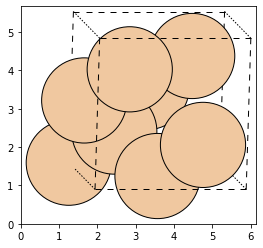

In [12]:
fig, ax = plt.subplots()
plot_atoms(SiDiamond, rotation='10x, 10y', ax=ax)

o bien, para poder rotarlo a mano (pero no se si anda en google colab)


In [13]:
#view(SiDiamond)

Una forma más presentable de visualizar las estructuras es usando por ejemplo [VESTA](http://www.jp-minerals.org/vesta/en/download.html) 

# Generamos la estructura con defectos Sustitucionales

Para poner un defecto sustitucional, basta con reemplazar un átomo del objeto atoms. Más fácil que en gmsh.

In [14]:
# hago copia de "SiDiamond", para no perderla y además poner defecto sustitucional.
SiBDiamond = SiDiamond.copy()
symbols = SiBDiamond.get_chemical_symbols()
symbols

['Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si']

Atom('B', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.0, 1.0, 1.0], index=1)
Atom('Si', [0.0, 2.0, 2.0], index=2)
Atom('Si', [1.0, 3.0, 3.0], index=3)
Atom('Si', [2.0, 0.0, 2.0], index=4)
Atom('Si', [3.0, 1.0, 3.0], index=5)
Atom('Si', [2.0, 2.0, 0.0], index=6)
Atom('Si', [3.0, 3.0, 1.0], index=7)


<AxesSubplot:>

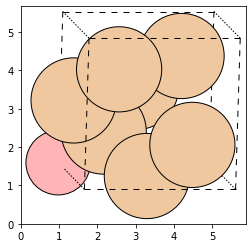

In [15]:
# Introduzco un átomo de BORO en el índice 0 de "SiBDiamond"; dopé con B en la posición [0,0,0].
symbols[0] = 'B'   # para hacerlo, modifico "symbols"
SiBDiamond.set_chemical_symbols(symbols)   # y a partir del "symbols" modificada, es que actualizo "SiBDiamond"
print_newatoms = [print(at) for at in SiBDiamond]
plot_atoms(SiBDiamond, rotation='10x, 10y')

**Aunque un poco más elegante sería**

1) pasar Objeto Atoms a una lista normal:

``` python
SiDiamondList = [at for at in SiDiamond]
```

2) cambiar el primer objeto de la lista:

``` python
SiDiamondList[0]=Atom('B', position=SiDiamond[0].position)
```

y despues volver a pasarlo a objeto Atoms:

``` python
SiBDiamond=Atoms(SiDiamondList, cell=SiDiamond.cell, pbc=True)
```

In [16]:
# Creo lista normal, con los elementos de la original "SiDiamond".
SiDiamondList = [at for at in SiDiamond]
# Con "atom" defino el átomo de B, le asigno posición que tenía el Si en "SiDiamond", y guardo en la lista "SiDiamondList".
SiDiamondList[0]=Atom('B', position=SiDiamond[0].position)
# Con "atoms", defino la celda (igual a la de "SiDiamond", usando comando ".cell") con condiciones periódicas de borde en los 3 ejes (pbc=True), a partir de
# lo que contiene "SiDiamondList".
SiCDiamond=Atoms(SiDiamondList, cell=SiDiamond.cell, pbc=True)
print_newnew_atoms = [print(at) for at in SiCDiamond]

Atom('B', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.0, 1.0, 1.0], index=1)
Atom('Si', [0.0, 2.0, 2.0], index=2)
Atom('Si', [1.0, 3.0, 3.0], index=3)
Atom('Si', [2.0, 0.0, 2.0], index=4)
Atom('Si', [3.0, 1.0, 3.0], index=5)
Atom('Si', [2.0, 2.0, 0.0], index=6)
Atom('Si', [3.0, 3.0, 1.0], index=7)


# Tareas
1.  convergencia en puntos K y en ondas planas
2. Calcular curva E-V  y ajustar parámetro de red. ¿ Cambia mucho al cambiar un átomo solo ?
3. Calcular estructura electrónica, i.e. densidad de estados. ¿Qué cambia ? 

# Definimios la calculadora

Primero, calculamos usando la celda de Si SIN DOPAR con B.

In [17]:
# Tomo expansión en ondas planas hasta "300 eV" (energía cinética de corte). Más agarre, más precisión.
# Divido el cubo en grilla de "5*5*5". Más divisiones, más precisión, más tiempo de cálculo.
calc = GPAW(mode=PW(300), xc='PBE', txt='SiDiamondExample.txt',kpts=[5,5,5])
SiDiamond.set_calculator(calc)
SiDiamond.get_potential_energy()

30.84122577365519

Segundo, calculamos usando la celda de Si DOPADA con B

In [18]:
# Tomo expansión en ondas planas hasta "300 eV" (energía cinética de corte). Más agarre, más precisión.
# Divido el cubo en grilla de "5*5*5". Más divisiones, más precisión, más tiempo de cálculo.
calc = GPAW(mode=PW(300), xc='PBE', txt='SiBDiamondExample.txt',kpts=[5,5,5])
SiBDiamond.set_calculator(calc)
SiBDiamond.get_potential_energy()

15.080646323767574

**Conclusión:** Al dopar Si diamante con un átomo de B en la posición (0,0,0), *la energía potencial se reduce prácticamente a la mitad*.

<div style="background:#999900"> esto en si no quiere decir mucho porque estas cambiando la composición química y porque no estas seguro de que el parametro de red sea correcto. La forma de comparar estas energías es calculando la energía de formación:
    </div>
    

    
$$ \Delta E_f = \dfrac{1}{N} \left( E_{compuesto} - \sum_{i} n_i E_i \right) $$

    
<div style="background:#999900">
donde $N$ es el número de átomos, $E_{compuesto}$ es la energía del compuesto calculada, $n_i$ es el número de átomos de la especie $i$ en el compuesto y $E_i$ es la energía por átomo del compuesto $i$ en su estructura de equilibrio. Es decir, tendrías que:
    1. Calcular la curva E-V para cada elemento del compuesto puro (ie Si diamond y boro loquefuere)
    2) calcular la curva E-B para el Si-B
    3) calcular la energía de formación
</div>

# K-point convergence 

Defino las dos estructuras en las que evaluaré la convergencia en puntos K:
- $SiDiamond$, sin dopar con B.
- $SiBDiamond$, dopada con B.

In [19]:
structures = [('pure', SiDiamond, 5.5), ('wBoron', SiBDiamond, 5.25)] # Nombre, estructura, parámetro de red.

In [20]:
print(structures[0])

('pure', Atoms(symbols='Si8', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)), 5.5)


In [21]:
print(structures[0][0])

pure


In [22]:
kpoints = [3, 4, 5,7,9,11,13,14,15] # Grillas a ensayar
Ekpt = {} # Guardaré, para cada estructura (name), la información de las grillas en un diccionario

Para no tener que hacer las cuentas de nuevo cada vez que corres este loop podes definir un archivo donde 
guradrar los resultados y probar si existe antes de hacer la cuenta

In [23]:
import os

In [24]:
calcsdir='calcs_kpoints'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [25]:
import pdb

In [26]:
for case in structures:
    name, struc, latpar = case
    Ekpt[name] = np.array([])
    for kpt in tqdm(kpoints):
        # Energía cinética de corte 300 eV. Divido celda en grilla de "kpt*kpt*kpt"
        gpawfile =os.path.join(calcsdir, f'{name}_kpts_{kpt}.gpaw')
        logfile = os.path.join(calcsdir, f'{name}_{kpt}.txt')
        calc = load_calc(gpawfile, mode=PW(300), txt=logfile, xc='PBE', kpts=[kpt,kpt,kpt])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ekpt[name]=np.append(Ekpt[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(gpawfile)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Imprimo energías potenciales de $SiDiamond$

In [27]:
print(Ekpt[structures[0][0]])

[3.82942323 3.84226177 3.85515322 3.85366022 3.84680203 3.84643687
 3.84849821 3.8486624  3.8487114 ]


Imprimo energías potenciales de $SiBDiamond$

In [28]:
print(Ekpt[structures[1][0]])

[1.87559471 1.87535473 1.88508079 1.87945832 1.87788234 1.87564313
 1.87482283 1.87463    1.87466355]


**Conclusión:** De nuevo, las energías asociadas al Si dopado con B son menores.

***Convergencia*** significa que la diferencia de energía entre un cierto K y el último K, dividida por la energía del último K, es menor a un determinado margen establecido.

**Este cociente** es lo que se grafica a continuación, en función del número de puntos K.

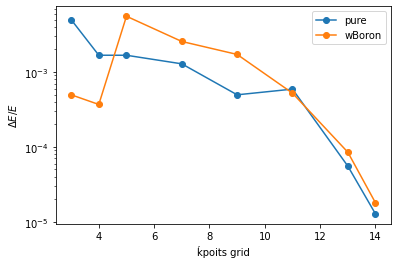

In [29]:
plots = [plt.plot(kpoints[:-1], econvergence(energies), '-o', label = struc) for struc, energies in Ekpt.items()]
plt.yscale('log')
plt.ylabel('$\Delta E / E$')
plt.xlabel('ḱpoits grid')
plt.legend()

**Conclusión:** Hay convergencia a partir de $K = 11$. Deberé tomar grillado de $11*11*11$.

In [30]:
KPT = 11

# cutoff convergence

A partir de aca hay que completar !

In [31]:
ecuts = [200, 250, 300, 400] # Energías cinéticas de corte (como la que habíamos usado de 300 eV arriba).
Ecutoff = {} # Guardaré, para cada estructura (name), la información de las energías de corte en un diccionario

<div style="background:#999900"> igual que antes, usamos archivos para evitar recalcular todo </div>

In [32]:
calcsdir = 'calcs_ecut'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [33]:
for case in structures:
    name, struc, latpar = case
    Ecutoff[name] = np.array([])
    progress = tqdm(ecuts)
    for ecut in progress:
        filename = os.path.join(calcsdir, f'{name}_{ecut}.gpaw')
        logfilename = os.path.join(calcsdir, f'{name}_{ecut}.txt')
        # Energía cinética de corte "ecut" eV. Divido celda en grilla de "KPT*KPT*KPT".
        calc = load_calc(filename, mode=PW(ecut), txt=logfilename, xc='PBE', kpts=[KPT,KPT,KPT])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ecutoff[name]=np.append(Ecutoff[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(filename)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [34]:
Ecutoff

{'pure': array([3.85598245, 3.84828234, 3.84643687, 3.84383355]),
 'wBoron': array([1.9960631 , 1.91424633, 1.87564313, 1.851634  ])}

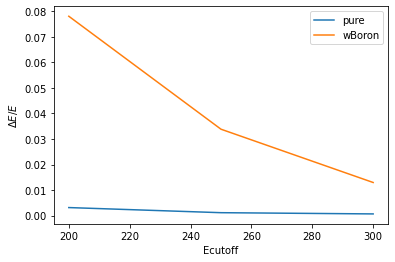

In [35]:
[plt.plot(ecuts[:-1], econvergence(energies), label = struc) for struc, energies in Ecutoff.items()]
plt.ylabel('$\Delta E /E$')
plt.xlabel('Ecutoff')
plt.legend()

**Conclusión:** Hay convergencia a partir de $E = 350$. Deberé tomar energía cinética de corte $ECUT = 350$.

In [36]:
ECUT = 350

# Lattice Parameter

Inicialmente había supuesto un parámetro de red $a=5$, pero ahora probaré con 10 valores en el entorno de $a=5$.


``` python
# Hago loop sobre los parámetros de red, y para dada estructura calculo la energía asociada a utilizar ese parámetro de red. Obendré energías en función de
# parámatro de red (en realidad cubo de parámetro de red, volumen), y así puedo obtener el parámetro de red que minimiza la energía.
latparams = {'diamond': np.linspace(4.8,5.5,10), 'wBoron': np.linspace(4.8, 5.5, 10)}
def evcurve(element: str, structure, sizes: np.ndarray, calculator):
    """
    Parametros:
    alement: str con el nombre de la estructura
    structure: nombre de a estructura para generar el atoms object.
    sizes: lista de parámetros de red
    calculator: calculadora GPAW.
    
    """
    print(f'working on {element} in {structure}')
    structures = []
    E = []
    V = []
    progress = tqdm(sizes)
    for a in progress:
        calc = GPAW(mode=PW(ECUT), xc='PBE', txt=f'{element}{structure}_{a}.txt',kpts=[KPT,KPT,KPT])
        structures.append(bulk(element, structure, a=a, cubic=True))
        structures[-1].set_calculator(calculator)
        E.append(structures[-1].get_potential_energy())
        V.append(structures[-1].get_volume())
    return {'E': E, 'V': V, 'strucs': structures}
```

<div style="background:999900" > en realidad la función de arriva hay que cambiarla un poco porque vos vas a quere darle los objetos atoms ya armados, en lugar de armarlos dentro del loop. Dentro del loop solo vas a querer cambarles el parámetro de red. </div>

In [37]:
structures

[('pure',
  Atoms(symbols='Si8', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  5.5),
 ('wBoron',
  Atoms(symbols='BSi7', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  5.25)]

In [38]:
latparcalcs = 'calcs_latpar'

In [39]:
if not os.path.exists(latparcalcs):
    os.makedirs(latparcalcs)

In [40]:
import ase, gpaw
def doevcurve(name: str, struc: ase.atoms.Atoms, sizes: np.ndarray, gpaw_kwargs:dict):
    """
    name: str con el nombre de la estructura
    struc: atoms object con la estructura a calcular
    sizes: np.ndarray con los parametros de red para esta estructura
    gpaw_kwargs: opciones para gpaw
    """
    E = []
    V = []
    progress = tqdm(sizes)
    for latpar in progress:
        gpawfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.gpaw')
        logfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.txt')
        gpaw_kwargs.update({'txt': logfile})
        calc = load_calc(gpawfile, **gpaw_kwargs)
        struc.set_cell(latpar*np.eye(3), scale_atoms=True) # ojo, esto vale solo para cubicas !
        struc.set_calculator(calc)
        V.append(struc.get_volume())
        E.append(struc.get_potential_energy())
        struc.calc.write(gpawfile)
    return {'V': V, 'E': E}
        
        

In [41]:
GPAW_KWARGS = dict(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT])

In [42]:
evcurves={}

In [43]:
for case in structures:
    name, struc, guess = case
    print(guess)
    latparams = np.linspace(guess*0.95, guess*1.05, 10)
    evcurves[name] = doevcurve(name,struc, latparams, GPAW_KWARGS)

5.5


  0%|          | 0/10 [00:00<?, ?it/s]

5.25


  0%|          | 0/10 [00:00<?, ?it/s]

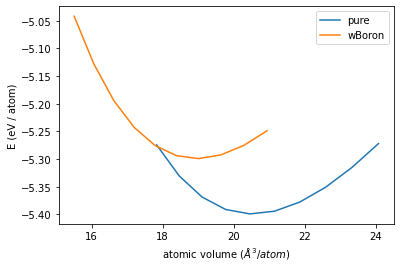

In [44]:
for (name, evcurve), case in zip(evcurves.items(), structures):
    structure = case[1]
    natoms = structure.get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=name)
plt.legend()
xlabel=plt.xlabel('atomic volume ($\AA ^3 / atom $)')
ylabel = plt.ylabel('E (eV / atom)')

# Ecuación de Estado 

In [45]:
eos = EquationOfState(evcurves['wBoron']['V'],evcurves['wBoron']['E'],eos='birchmurnaghan')

In [46]:
eos.fit()

(151.70250051182663, -42.39259906203289, 0.580117610335271)

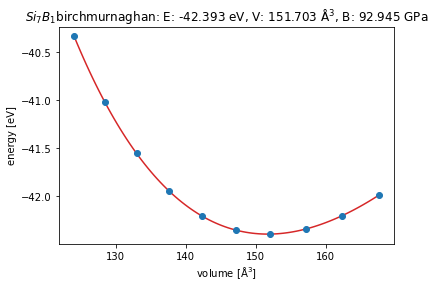

In [49]:
ax = eos.plot()
title = ax.get_title()
newtitle = ax.set_title('$Si_7 B_1$' + title)

In [50]:
eqa = eos.v0**(1/3)

In [51]:
eqa

5.333319233391247

# Densidad de Estados 

A partir de aca tendrías que completar!

In [ ]:
eqstruc = bulk('l','fcc',a=eqa, cubic=True)
calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[11,11,11], txt='equilibrium.txt')
eqstruc.set_calculator(calc)
eqstruc.get_potential_energy()

e,dos = eqstruc.calc.get_dos(npts=500)
ef = eqstruc.calc.get_fermi_level()

In [ ]:
plt.plot(e-ef,dos)
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')

In [ ]:
eqstruc.calc.write('Alfcceq.gpw')

In [ ]:
bscalc = GPAW('Alfcceq.gpw').fixed_density(nbands=20, symmetry='off', txt='bs.txt', kpts={'path': 'GXMGRX', 'npoints': 60}, convergence={'bands': 8})

In [ ]:
bs = bscalc.band_structure()

In [ ]:
bs = bs.subtract_reference()

In [ ]:
ax = bs.plot(emin=-12, emax=5)
ax.set_ylabel('$E-E_f$ (eV)')